# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. 
## Σύστημα συστάσεων βασισμένο στο περιεχόμενο
## Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 

Χατζηχαραλάμπους Γεώργιος 03114709 <br/>
Βακαλοπούλου Μυρσίνη 03114308 <br/>
Ομάδα Α29

In [0]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn


Requirement already up-to-date: pip in /home/gxx/anaconda3/lib/python3.7/site-packages (18.1)
Requirement already up-to-date: numpy in /home/gxx/anaconda3/lib/python3.7/site-packages (1.15.4)
Requirement already up-to-date: pandas in /home/gxx/anaconda3/lib/python3.7/site-packages (0.23.4)
Requirement already up-to-date: nltk in /home/gxx/anaconda3/lib/python3.7/site-packages (3.4)
Requirement already up-to-date: scikit-learn in /home/gxx/anaconda3/lib/python3.7/site-packages (0.20.2)


## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με περίπου 40.000 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [1]:
import pandas as pd

dataset_url = "https://drive.google.com/uc?export=download&id=1PdkVDENX12tQliCk_HtUnAUbfxXvnWuG"
# make direct link for drive docs this way https://www.labnol.org/internet/direct-links-for-google-drive/28356/
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3, error_bad_lines=False)

Η ομάδα μας έχει index 29 και θα εργαστεί στο αντίστοιχο dataset από ταινίες.

In [7]:
import numpy as np

# βάλτε το seed που αντιστοιχεί στην ομάδα σας
team_seed_number = 29

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1NkzL6rqv4DYxGY-XTKkmPqEoJ8fNbMk_"
df_data_2 = pd.read_csv(movie_seeds_url, header=None, error_bad_lines=False)

# επιλογή 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(np.float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries

5000


- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=99` (την εκατοστή) θα γράψουμε `print(corpus[99])`.

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο

Η πρώτη εφαρμογή που αναπτύσουμε είναι ένα σύστημα συστάσεων ταινιών βασισμένο στο περιεχόμενο (content based recommender system), κατά το οποίο προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο και συγκεκριμένα με βάση τις συνόψεις των ταινιών (corpus). 


## Μετατροπή σε TFIDF

Το πρώτο βήμα είναι να μετατρέψετε το corpus σε αναπαράσταση tf-idf με σκοπό να διατηρήσουμε για το corpus της κάθε ταινίας μόνο τις λέξεις που δίνουν πληροφορία για το θέμα και το περιεχόμενο της ταινίας. H συνάρτηση tokenize και ο πίνακας my_words προσδοκούν στη βελτιστοποίηση του vectorizer παρακάτω.

In [0]:
import nltk
nltk.download('wordnet') # απαραίτητα download για τους stemmer/lemmatizer
nltk.download('rslp')
nltk.download('punkt')
nltk.download('stopwords') # κατεβάζουμε ένα αρχείο που έχει stopwords στα αγγλικά
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer = PorterStemmer()

def tokenize(document):   #Η συνάρτηση αυτή έχεται σαν όρισμα ένα document κι επιστρέφει μία λίστα από λέξεις που δίνουν πληροφορία για την ταινία. Οι λέξεις είναι stemmed
    words = nltk.word_tokenize(document)
    document = document.lower()
    my_words=['film','director','plot','movie','scenes','title','plot','actor','writer','man','woman','human']
    filtered_words = [word for word in words if word not in stopwords.words('english') + list(string.punctuation)+my_words]
    stem_words = [porter_stemmer.stem(word) for word in filtered_words]
    return stem_words

[nltk_data] Downloading package wordnet to /home/gxx/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package rslp to /home/gxx/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to /home/gxx/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/gxx/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Ακολούθως ορίζουμε τον vectorizer που θα φέρει σε tf-idf όλα τα corpus των ταινιών. Στην προσπάθεια βελτιστοποίησης του vectorizer, εκτός από τον ορισμό της tokenize, θέτουμε επίσης τις παραμέτρους max_df=0.5 και min_df=10, 
κόβοντας έτσι τις λέξεις που έχουν διατηρηθεί από τον tokenizer αλλά είτε είναι υπερπληθείς στα corpus όλων των ταινιών (υψηλό df), 
είτε είναι σπάνιες (χαμηλό df).

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.externals import joblib

maxf=0.5
minf=10
vectorizer = TfidfVectorizer(tokenizer=tokenize, stop_words='english', max_df=maxf, min_df=minf)
vectorizer.fit(corpus)
%time corpus_tf_idf = vectorizer.transform(corpus).toarray()
joblib.dump(corpus_tf_idf, 'corpus_tf_idf.pkl') 

In [0]:
#Επαναφορά του corpus_tf_idf

from sklearn.externals import joblib

corpus_tf_idf = joblib.load('corpus_tf_idf.pkl')

## Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων περιλαμβάνει τη συνάρτηση `content_recommender`η οποία δέχεται μία `target_movie` και ένα `max_recommendations`. Η συνάρτηση επιστρέφει τις `max_recommendations` στο πλήθος ταινίες οι οποίες είναι οι πλησιέστερες ως προς το περιεχόμενο (με βάση το corpus).

In [0]:
#Συνάρτηση για εκτύπωση αποτελεσμάτων

def print_movie_details(ID=100):
    print("ID:",ID)
    print()
    print("Title: ",titles[ID])
    print()
    print("Summary: ",corpus[ID]) 
    print()
    print("Categories: ",categories[ID])

In [0]:
import scipy as sp

def content_recommender(target_movie=100,max_recommendations=3):
    size=corpus_tf_idf.shape[0]
    cos_value = np.zeros(size)
    cos_index = [0]*size;

    for i in range(size):     
        cos_value[i]= 1-sp.spatial.distance.cosine(corpus_tf_idf[i],corpus_tf_idf[target_movie]);#bazume 1-(ans) epeid
        # to scipy exi orisi t cosine similarity san 1-cosine(),kai to kanume etsi gia na to ferume pio katanoiti morf
        #diladi tora i apostasi pu bgazei, einai poso konta mas einai
        cos_index[i]=i;

    z = list(zip(cos_index,cos_value))
   
    distance=tuple(z)
    from operator import itemgetter
    distance=sorted(distance, key=lambda tup: tup[1],reverse=True)
    recommendations=distance[1:max_recommendations+1]#dialego ta max_recommendatios kalitera tuples
    print(recommendations)
    recommendations=[i[0] for i in recommendations]#dialego ta index tn max_recommendatios tuples
    print("Target Movie ")
    print_movie_details(target_movie)
    print()
    print("Recommendations Movies ")
    for x in recommendations:
        print_movie_details(x)
    return recommendations;
    

In [0]:
content_recommender(23,8) 

[(2878, 0.6879774161795128), (1868, 0.6498832301158012), (3144, 0.6029593471595948), (1658, 0.5049827879227785), (2457, 0.45804682335728475), (3598, 0.2803969561307489), (4333, 0.2651345722394166), (1124, 0.2220946932025747)]
Target Movie 
ID: 23

Title:  ['Sasural']

Summary:  Shekhar lives a poor lifestyle along with his maternal uncle, Dharamdas; his aunt; a cousin, Sita - who is separated from her husband, Mahesh; and also has a sister, Gauri, who had eloped with her lover and everyone believes is dead. He studies in college along with wealthy fellow collegian, Bela. Both do not get along, but that changes when her dad comes to know about Shekhar's good character and thinks that he will be a suitable son-in-law. He approaches Dharamdas and arranges their marriage with the condition that Shekhar move in with his family, to which Dharamdas and Shekhar agree but Bela's mom is displeased as she would like her daughter to marry Rajan Murari, the son of their employee, Govindram. Despite

[2878, 1868, 3144, 1658, 2457, 3598, 4333, 1124]

In [0]:
#Αποθήκευση του τελικού πίνακα corpus_tf_idf

from sklearn.externals import joblib
joblib.dump(corpus_tf_idf, 'corpus_tf_idf.pkl') 

## Βελτιστοποίηση


Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε τη για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. Μπορείτε επίσης να βελτιστοποιήσετε τη συνάρτηση παρατηρώντας πολλά φαινόμενα που το σύστημα εκλαμβάνει ως ομοιότητα περιεχομένου ενώ επί της ουσίας δεν είναι επιθυμητό να συνυπολογίζονται. Ταυτόχρονα, μια άλλη κατεύθυνση της βελτιστοποίησης είναι να χρησιμοποιείτε τις παραμέτρους του `TfidfVectorizer` έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που θα αρχίσει να εμφανίζονται επιπτώσεις στην ποιότητα των συστάσεων. 




## Επεξήγηση επιλογών και ποιοτική ερμηνεία

Σε markdown περιγράψτε πώς προχωρήσατε στις επιλογές σας για τη βελτιστοποίηση της `TfidfVectorizer`. Επίσης σε markdown δώστε 10 παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν καλά αποτελέσματα μέχρι `max_recommendations` (5 και παραπάνω) και σημειώστε συνοπτικά ποια είναι η θεματική που ενώνει τις ταινίες.

Δείτε [εδώ](https://pastebin.com/raw/ZEvg5t3z) ένα παράδειγμα εξόδου του βελτιστοποιημένου συστήματος συστάσεων για την ταίνία ["Q Planes"](https://en.wikipedia.org/wiki/Q_Planes) με την κλήση της συνάρτησης για κάποιο seed `content_recommender(529,3)`. Είναι φανερό ότι η κοινή θεματική των ταινιών είναι τα αεροπλάνα, οι πτήσεις, οι πιλότοι, ο πόλεμος.

## Βελτιστοποίηση TfidfVectorizer
Αρχικά αφαιρούμε λέξεις όπου είναι πολύ κοινές και δεν μας δίνουν ιδαίτερη πληροφορία όσο αφορά κάποια ταινία. Για αυτό το σκοπό, χρησιμοποιήσαμε ένα δικό μας tokenizer, ώστε να μπορούμε να αφαιρέσουμε επιπλέον λέξεις από αυτές που δίνει το έτοιμο λεξικό "english" της συνάρτησης TfidfVectorizer. Στο tokenizer, επιπλέον από το λεξικό του nltk (stopwords), εισάγαμε και ένα μικρό δικό μας λεξικό. Σε αυτό περιέχονται λέξεις συχνά χρησιμοποιούμενες και χωρίς σημασιολογική χρησιμότητα στις περιλήψεις ταινιών λ.χ film,plot κτλπ. Έπειτα δοκιμάσαμε δύο διαφορετικές τεχνικές για να μεταμορφώσουμε τις λέξεις, ώστε να μπορούμε πιο εύκολα να τις συγκρίνουμε μεταξύ τους έχοντας μια ευρύτερη κοινή βάση λέξεων. Η μία τεχνική είναι η lemmatization, η οποία αναφέρεται στην απομάκρυνση της κλίσης των λέξεων. Η δεύτερη τεχνική είναι η stemming η οποία αναφέρεται στη αφαίρεση της κατάληξης της λέξης. Έπειτα από πειραματισμό και με τις δύο χρησιμοποιώντας τη content_recommender καταλήξαμε ότι καλύτερη είναι η stemming. Το να χρησιμοποιηθούν και οι δύο δεν έχει ιδιαίτερο νόημα καθώς δίνουν περίπου παρόμοια αποτελέσματα όσο αφορά τη δουλειά που κάνουν. Λόγω ότι το λεξικό που έχουμε φτιάξει προέρχεται από περιλήψεις διαφόρων και πολλών ταινιών, υπάρχουν λέξεις όπου είναι πολύ σπάνιες και μπορεί λ.χ να εμφανίζονται μόνο στη περίληψη μιας ταινίας. Προφανές παραδείγματα είναι τα ονόματα των πρωταγωνιστών της ταινίας, όπου υπάρχουν μόνο στη περίληψη της συγκεκριμένης ταινίας και άρα δε θα είναι χρήσιμο να τα αναπαραστήσουμε. Λόγω αυτού έχουμε βάλει τόσο άνω όσο και κάτω όριο όσο αφορά τη συχνότητα εμφάνισης των λέξεων. Πιο συγκεκριμένα έχουμε καταλήξει μετά από πολλούς ελέγχους, ότι τα καλύτερα άνω - κάτω όρια είναι 50% και 10-15  λέξεις. Λέμε 10-15  λέξεις καθώς σε αυτό το διάστημα όποια επιλογή κάναμε μας έδινε ικανοποιητικά και αρκετά παραπλήσια αποτελέσματα. Να αναφέρουμε ότι με το άνω όριο 50% εννοούμε ότι αγνοούμε τους όρους που εμφανίζονται σε ποσοστό 50% των κειμένων και πάνω. Αντίστοιχα με 10-15 λέξεις κάτω όριο εννοούμε ότι αγνοούμε τους όρους οι οποίοι εμφανίζονται σε αριθμό μικρότερο από 10-15  λέξεις (ότι αριθμό και αν διαλέξουμε εν τέλη). Σημαντικό να αναφέρουμε ότι μετά τη προεπεξεργασία του λεξικού για να μπορούμε να εφαρμόσουμε μηχανική μάθηση, μετασχηματίζουμε το λεξικό σε διανυσματική αναπαράσταση χρησιμοποιώντας τη αναπαράσταση TFIDF. 
Σαν τελικό στάδιο δεδομένου του μεγάλου πίνακα αλλά και γενικότερα μεγάλου dataset(θα μπορούσαμε να είχαμε ακόμη δραματικά μεγαλύτερο),δοκιμάσαμε να χρησιμοποιήσουμε επίσης και τη μέθοδο pca (Principle Component Analysis) για να μεταφερθούμε σε ένα πιο κατάλληλο σύστημα συντεταγμένων, με λίγότερες (και πιο βασίκες) συνιστώσες. Με λίγα λόγια στο συγκεκριμένο project, δοκιμάστηκε για μείωση της διάστασης του διανύσματος δεδομένων μας αλλά και για να δούμε κατα πόσο επηρεάζει τα αποτελέσματα. 


## Παραδείγματα ταινιών και συστάσεων
Ο τρόπος όπου ελέγχουμε τη ποιότητα των αποτελεσμάτων για να μπορούμε να συντονίσουμε κατάλληλα τις ρυθμίσεις του TfidfVectorizer είναι τρέχοντας τη content_recommender και ελέγχοντας αν οι ταινίες που μας επιστρέφει είναι σημασιολογικά κοντά.
Μερικά παραδείγματα ταινιών που εμφανίζουν καλά αποτελέσματα είναι τα εξής:

1) id 23 (Sasural):<br/>
-Kasoor, Jurm, Shaapa, China Town, Bahar, Jagriti <br/>
-Bollywood, σχέσεις μεταξύ παντρεμένων ή/και οικογένειας, εμπλέκεται θάνατος ή κάποιο μυστήριο.<br/>

2) id 25 (Widow's Perverted Hell):<br/>
-Irresistable Angel: Suck It All Up, Ijé, Mabel's Married Life, Dona Flor and Her Two Husbands, The Heavenly Body, Casino Raiders <br/>
-άντρες συζύγοι , θάνατος αντρών συζύγων, σεξ<br/>

3) id 4 (The Day the Earth Caught Fire): <br/>
-Seven Days to Noon, War of the Planets, Descent, 6 Angels, Hiroshima, Gekijōban Pocket Monsters Diamond & Pearl 2008<br/>
-πυρηνικές βόμβες, ζητήματα που αφορούν όλον τον πλανήτη γη δηλαδή παγκόσμιες καταστροφές, παγκόσμιοι κίνδυνοι, διαπλανητικές μάχες-συμβάντα<br/>

4) id 1994 (Lies My Father Told Me):<br/>
-Cedie, Seachd: The Inaccessible Pinnacle, The Garden, Courage Mountain, Manivathoorile Aayiram Sivarathrikal, Silambattam <br/>
-εμπλέκεται η οικογένεια του πρωταγωνιστή (γονείς) και κύριο ρόλο έχει ο παππούς, family movies <br/>

5) id 3196 (Pig Business):<br/>
-The Meatrix, Animal Farm, The Chicken of Tomorrow, Death Dimension, The World According to Monsanto, Tie Xi Qu: West of the Tracks<br/>
-ζώα, φάρμες, καλλιέργειες, documentary<br/>

6) id 2120 (From Time to Time):<br/>
-Secret Well, Wake Me When The War Is Over, Girl Trouble, El Sur, The Sea Wolves, Crying... Silicon Tears<br/>
-World War II, μυστικά που σχετίζονται με οικογένειες, παιδιά που ανακαλύπτουν μυστικά σε σχέση με τις οικογένειές τους<br/>

7) id 4988 (Arangetram):<br/>
-Ramayanam, Oru Muthassi Katha, Lanka, Malayan, Ayiram Poi, Beasts of Prey<br/>
-Ινδικές ταινίες (Tamil Cinema), Drama<br/>

8) id 3008 (Death Line):<br/>
-Wrong Turn 5, Robinson Crusoe, Enchanted Island, Dying Breed, Union Station, Weekend<br/>
-κανίβαλλοι, βιαστές, Horror, Slasher<br/>
-Η τελευταία ταινία (Weekend)δεν έχει καμία σχέση με τις υπόλοιπες και απλά προτείνεται λόγω του ονόματος Russell που είναι κοινό στα summaries των 2 ταινιών.<br/>

9) id 3918 (Invisible Agent):<br/>
-The Scarlet Coat, Tunnel War, Nazi Agent, The Eagle Has Landed, The Secret Code, The Thin Red Line<br/>
-κυβερνητικά μυστικά, κατάσκοποι, πράκτορες, μυστικά και διαπλοκές μεταξύ κρατών, στρατός<br/>

10) id 2918 (The Stars Shine):<br/>
-Cinesound Varieties, We'll Meet Again, Schultze Gets the Blues, Paris 36, America's Music: The Roots of Country, Creeporia<br/>
-Musical, μουσική, χορευτές, η πρωταγωνίστρια είναι ηθοποιός<br/>


Καθώς ελέγχαμε το recomendation σύστημα αντιληφθήκαμε ότι αρκετές φορές, το σύστημα προτείνει ταινίες λόγω κοινών ονομάτων των πρωταγωνιστών. Κάτι τέτοιο είναι ανεπιθύμητο. Ψάξαμε μήπως υπάρχει κάποιο σύνολο με τα αγγλικά ονόματα όπως και με τα άρθα στην python για να το συμπεριλάβουμε στον tokenizer αλλά δεν βρήκαμε κάτι ακριβώς αυτό που θέλαμε. Σίγουρα μια επιπλέον βελτιστοποίηση που μπορεί να γίνει μελλοντικά είναι η αφαίρεση αυτών των λέξεων.

Σημειώνεται ότι επειδή η ανάλυση που κάνουμε βασίζεται στις περιλήψεις και μόνο των ταινιών
δεν περιμένουμε εκπληκτικά αποτελέσματα όσο αντιπροσωπευτικό κι αν είναι το corpus. Ουσιαστικά το σύστημα προσπαθεί να εξάγει ομοιότητες ταινιών όσον αφορά το είδος τους
χρησιμοποιώντας ομοιότητες λέξεων μεταξύ των περιλήψεων των ταινιών ενώ πολλές ταινίες έχουν πολύ συνοπτικές έως ανύπαρκτες περιλήψεις. Ακόμα παρατηρήσαμε ότι σε κάποιες ταινίες, ενώ οι περιγραφές δίνουν κάποια κατηγορία ξεκάθαρα, αυτή η κατηγορία δεν αναγράφεται στο πεδίο categories. Συγκεκριμένο παράδειγμα η ταινία με ID=1268 που η περιγραφή κάνει ξεκάθαρο ότι η ταινία είναι romance αλλά αυτό δεν αναγράφεται στο categories, αναγράφεται μόνο το drama. Τέλος, να επισημάνουμε ότι οι περιγραφές προέρχονται από διαφορετικά άτομα οπότε από διαφορετικούς γραφικούς τύπους κάτι που κάνει την ομοιότητα στο περιεχόμενο με βάση τις λέξεις ακόμα πιο αυθαίρετο.



In [0]:
#Επαναφορά του corpus_tf_idf
from sklearn.externals import joblib
corpus_tf_idf = joblib.load('corpus_tf_idf.pkl')

# Εφαρμογή 2.  Σημασιολογική απεικόνιση της συλλογής ταινιών με χρήση SOM


## Δημιουργία dataset
Στη δεύτερη εφαρμογή, με τη χρήση Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες του data set μας με τρόπο χωρικά συνεκτικό ως προς τα corpus τους. 



In [0]:
import numpy as np

def build_final_set(doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation (We have already done it before,so it's not needed now)
    dense_tf_idf = corpus_tf_idf[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
        # η somoclu θέλει δεδομένα σε float32
    return np.array(final_set, dtype=np.float32)

In [0]:
#Ο τελικός πίνακας πάνω στον οποίο θα δουλέψουμε
set=5000
final_set = build_final_set(set)

Τυπώνουμε τις διαστάσεις του τελικού dataset μας. Χωρίς βελτιστοποίηση του TFIDF θα έχουμε περίπου 50.000 χαρακτηριστικά.

In [0]:
final_set.shape

(5000, 6249)

## Εκπαίδευση χάρτη SOM

In [0]:
# install somoclu
!pip install --upgrade somoclu
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

Requirement already up-to-date: somoclu in /home/gxx/anaconda3/lib/python3.7/site-packages (1.7.5)


Μελετώντας διάφορα μεγέθη χάρτη όπου ο αριθμός των νευρώνων μεγαλώνει, παρατηρούμε σαφώς μεγάλη αύξηση στο χρόνο εκπαίδευσης. Γενικά στο train διατηρήσαμε 100 epochs. Αρχικά χρησιμοποιήσαμε χάρτη 10 x 10 κι ένα μικρό υποσύνολο των ταινιών (1000). Δοκιμάσαμε επίσης να χρησιμοποιήσουμε kmeans με k=10 και k=20. Με αυτές τις υπερπαραμέτρους δοκιμάσαμε 2 από τα καλύτερα σύνολα corpus_tf_idf που είχαν προκύψει από τo recomendation κι επιλέξαμε τελικά το καλύτερο (με βάση τη συνάρτηση ελέγχου print_cluster_neurons_movies_report) με το οποίο συνεχίσαμε για μελέτη μεγαλύτερων final_set, χαρτών και K. Χρησιμοποιήσαμε την `time` για έλεγχο των χρόνων εκπαίδευσης. Τα αποτελέσματα για αυτές τις εκτελέσεις σχολιάζονται παρακάτω.

In [0]:
#train som
n_rows, n_columns = 23, 23
som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
%time som.train(final_set,epochs=100)

CPU times: user 1h 14min 49s, sys: 11.8 s, total: 1h 15min 1s
Wall time: 22min 41s


In [43]:
#som-cluster

from sklearn.cluster import KMeans

k=40
algorithm = KMeans(k)
som.cluster(algorithm=algorithm)

#store som 
joblib.dump(som, 'som.pkl') 

['som.pkl']

In [44]:
#load som

from sklearn.externals import joblib

som = joblib.load('som.pkl')
bmus = som.bmus

Στη συνέχεια, εμφάνιζουμε χάρτη και clusters για το αντίστοιχο som που κάναμε load.

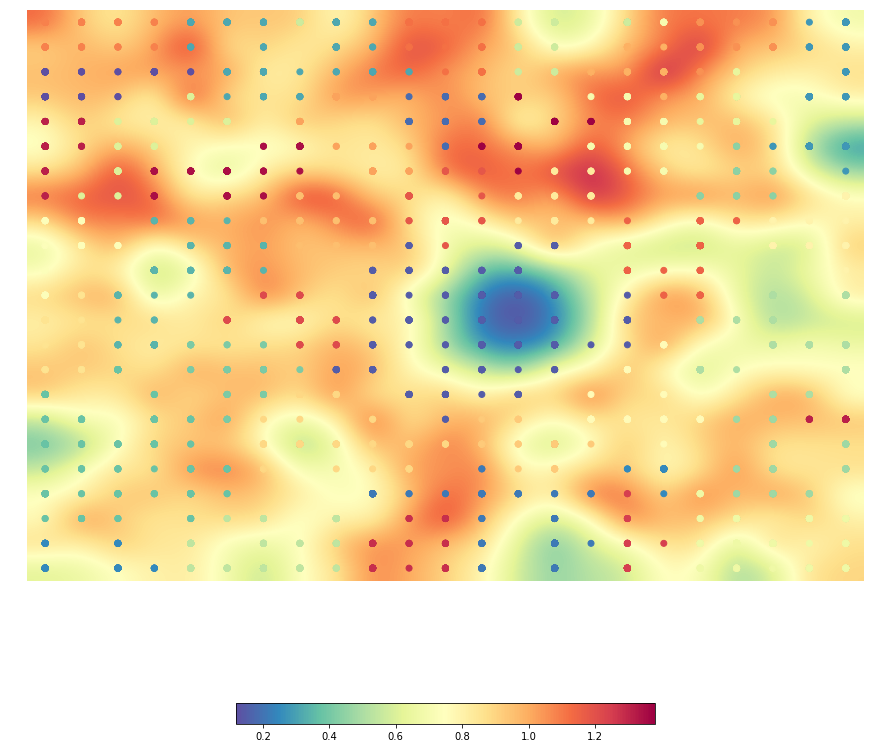

clusters
[[30 30 30 30  6  6  6 14  6  6 31 31 31 14 14 14 14 18 29 29 29  5  5]
 [30 30 30 30  6  6  6  6  6  6 31 31 31 14 14 14 27 27 29 29 29  5  5]
 [ 0  0  0  0  0  6  6  6  6  6  6 31 31 14 14 27 27 27 29 16 16  5  5]
 [ 0  0  0 15 15  6  6  6 28 28  2  2  2 39 39 18 18 27 16 16 16  5  5]
 [37 37 15 15 15 15  6 28 28 28  2  2  2 39 39 39 18 18 16 16 16  5  5]
 [37 37 15 15 38 38 38 38 28 28 28  2 39 39 39 18 18 18 18 10  5  5  5]
 [37 15 15 38 38 38 38 38 28 28 28 33 33 39 22 22 18 18 10 10 10  5  5]
 [37 15 15 38 38 38 38 26 26 28 33 33 33 22 22 22 22 10 10 10 10 21 21]
 [19 19 19  7  7  7 26 26 26 26 33 33 33 22 22 22 32 32 32 32 21 21 21]
 [19 19 19  7  7  7  7 26 26 26  1 33  1  1  1 32 32 32 32 21 21 21 21]
 [19 19  7  7  7  7  7 26 26  1  1  1  1  1  1 32 32 32 32 12 21 21 21]
 [19 23  7  7  7  7 34 34  1  1  1  1  1  1  1  1  1 32 32 12 12 12 12]
 [23 23  7  7  7 34 34 34 34  1  1  1  1  1  1  1  1 12 12 12 12 12 12]
 [23 23  7  7  9  9  9 34 34  1  1  1  1  1  1  1  1 20

In [45]:
#Umatrix som
som.view_umatrix(bestmatches=True, figsize=(15, 15), colorbar=True) 

#Clusters
clusters = som.clusters
print("clusters")
print(clusters)

ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)
# το return_inverse επιστρέφει και τους δείκτες indices
ubmus_indexes = np.unique(indices)

print(bmus.shape)
print (ubmus)
print(indices)
print (ubmus_indexes.shape)

In [46]:
# visualize Clusters-size 

def get_key(item):
    return item[1] #sort according counts

uclusters, counts = np.unique(som.clusters, return_counts=True)
ar = list(zip(uclusters, counts))
sorted_ar = sorted(ar, key=get_key) 

unziped = list(zip(*sorted_ar))
print("Clusters sorted by increasing number of neurons")
print("Cluster Index")
print("Number of Neurons")
print(list(unziped[0]))
print(list(unziped[1]))

Clusters sorted by increasing number of neurons
Cluster Index
Number of Neurons
[27, 2, 23, 29, 0, 10, 16, 30, 31, 34, 35, 36, 37, 19, 22, 33, 39, 14, 25, 4, 9, 18, 26, 15, 21, 28, 11, 38, 20, 32, 5, 13, 17, 3, 24, 6, 7, 12, 8, 1]
[6, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 11, 12, 12, 12, 13, 13, 14, 14, 15, 17, 17, 19, 19, 21, 22, 25, 35, 50]


## Ποιότητα U-Matrix

Για την ποιότητα του U-Matrix παρατηρήσαμε ότι όσο μικρότερο ήταν το final_set , τόσο λιγότερο ξεκάθαρα ήταν τα clusters, δηλαδή δεν διακρίνονταν οι μπλε και κόκκινες περιοχές το ίδιο με μεγαλύτερο final_set. To ίδιο ισχύει και για το μέγεθος του grid. Μικρό μέγεθος δεν διευκολύνει τη διακριση των clusters, κάτι που είναι λογικό καθώς όσο μεγαλώνει ο χάρτης γίνεται και πιο μεγάλη η ανάλυση των αποτελεσμάτων.

O τελικός μας χάρτης είναι αρκετά καλός. Φαίνονται περιοχές με χρώματα κίτρινα μπλε (clusters) τα οποία όντως περιβάλονται από κόκκινες περιοχές (μεγαλύτερη απόσταση νευρώνων - σύνορα clusters). 

Γενικά, σημειώνεται ότι υπάρχαν τιμές για χάρτη που έδιναν ελάχιστα καλύτερα οπτικά αποτελέσματα στο U-Matrix. Όμως, καθώς ο τελικός στόχος της εφαρμογής είναι η όσο το δυνατόν ορθότερη ομαδοποίηση των ταινιών με βάση τις κατηγορίες, δώσαμε μεγαλύτερη έμφαση στα αποτελέσματα της συνάρτησης αξιολόγησης, όπως εξηγήσαμε και παραπάνω. Για παράδειγμα, ο χάρτης 30x30 έδινε λίγο καλύτερο οπτικό αποτέσμα αλλά η κατηγοριοποίηση δεν βελτιωνόταν σε σχέση με μικρότερους χάρτες.


## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης με το tf-idf και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. Για το σκοπό αυτό υλοποιούμε την `print_cluster_neurons_movies_report` η οποία συμπεριφέρεται με τον τρόπο που περιγράφηκε στην εκφώνηση, δηλαδή δέχεται σαν όρισμα το ID ενός cluster και εκτυπώνει τις κατηγορίες των ταινιών του cluster μαζί με τη συχνότητα εμφάνισής τους. Από αυτό μπορούμε να κρίνουμε πόσο εύλογη ήταν η ομαδοποίηση των συγκεκριμένων ταινιών.



Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.   

In [47]:
def get_key(item):
    return item[1]


def print_categories_stats(movies): #movies is a list of movie-ID’s
    cluster_categories = []
    for i in movies:
        token = categories[i][0]
        token = token.split(",")
        #categories[ID] is list with 1 string inside. token is string
        for categ in token:
            categ = categ.strip()
            cluster_categories.append(categ)
        
    u_cluster_categories, counts = np.unique(cluster_categories, return_counts=True)
    ar = list(zip(u_cluster_categories, counts))
    sorted_ar = sorted(ar, key=get_key, reverse=True)
    print(sorted_ar)

    
def neuron_movies_report(neurons):  #neurons is a list of bmus(neurons)-indexes 
    movies = []
    #find movies in these neurons (through indices)
    for i in indices: #indices is global (computed above)
        if i in neurons: #if this neuron is in the given ones (bmus)
            movies.append(indices.index(i)) #append the movie-ID
    print_categories_stats(movies)

    
def print_cluster_neurons_movies_report(cluster): #cluster is the ID of a cluster
    neuron_indexes = []
    bmus_indexes = []
    #find the neurons that are in the cluster
    #clusters is the global matrix
    for i in range(len(clusters)):
        for j in range(len(clusters[0])):
            if clusters[i][j] == cluster:
                neuron_indexes.append(n_columns*i + j) #append the index of the neuron
    print("Cluster ID: ", cluster)
    print("Number of neurons of Cluster : ", len(neuron_indexes))
    for neuron in neuron_indexes: #neuron is the index of a neuron
        if neuron in ubmus_indexes: #ubmus_indexes is global
            bmus_indexes.append(neuron)
    
    neuron_movies_report(bmus_indexes)

In [48]:
n_rows, n_columns = 23, 23
k=40

indices = list(indices)
for i in range(k):
    print_cluster_neurons_movies_report(i)
    print()

Cluster ID:  0
Number of neurons of Cluster :  8
[('"Drama"', 63), ('"World cinema"', 41), ('"Comedy"', 27), ('"Crime Fiction"', 24), ('"Thriller"', 24), ('"Film noir"', 22), ('"Mystery"', 22), ('"Black-and-white"', 19), ('"Crime Thriller"', 19), ('"Bollywood"', 8), ('"Chinese Movies"', 3), ('"Melodrama"', 3), ('"Romance Film"', 3), ('"Horror"', 2), ('"Japanese Movies"', 2), ('"Adventure"', 1)]

Cluster ID:  1
Number of neurons of Cluster :  50
[('"Drama"', 545), ('"Romance Film"', 120), ('"Musical"', 78), ('"Black-and-white"', 73), ('"Comedy film"', 50), ('"War film"', 46), ('"Silent film"', 29), ('"Indie"', 24), ('"Short Film"', 24), ('"Adventure"', 22), ('"Animation"', 22), ('"Comedy-drama"', 20), ('"Family Film"', 20), ('"Fantasy"', 20), ('"Horror"', 19), ('"Comedy"', 18), ('"Thriller"', 16), ('"Melodrama"', 13), ('"Western"', 13), ('"Children\'s Fantasy"', 11), ('"Children\'s"', 11), ('"Children\'s/Family"', 11), ('"Film noir"', 11), ('"Mystery"', 10), ('"Action"', 9), ('"Chinese 

[('"Drama"', 101), ('"Black-and-white"', 40), ('"Adventure"', 19), ('"Fantasy"', 14), ('"Action/Adventure"', 7), ('"Fantasy Adventure"', 7), ('"Filipino Movies"', 7), ('"Horror"', 7), ('"Monster movie"', 7), ('"Science Fiction"', 7), ('"Historical fiction"', 5), ('"Bollywood"', 4), ('"Family Film"', 4), ('"Historical Epic"', 4), ('"War film"', 4), ('"Spy"', 1), ('"Swashbuckler films"', 1)]

Cluster ID:  35
Number of neurons of Cluster :  8
[]

Cluster ID:  36
Number of neurons of Cluster :  8
[]

Cluster ID:  37
Number of neurons of Cluster :  8
[('"Horror"', 39), ('"B-movie"', 29), ('"Action/Adventure"', 28), ('"Comedy"', 27), ('"Parody"', 27), ('"Crime Thriller"', 23), ('"Drama"', 18), ('"Action"', 17), ('"Crime Fiction"', 17), ('"Supernatural"', 16), ('"Thriller"', 16), ('"Creature Film"', 13), ('"Monster movie"', 13), ('"Sci-Fi Horror"', 13), ('"Science Fiction"', 13), ('"World cinema"', 11), ('"Black comedy"', 10), ('"Cult"', 10), ('"Horror Comedy"', 10), ('"Family Drama"', 6), ('

## Σχόλια για τη βελτιστοποίηση του χάρτη

Για να βρούμε τη βέλτιστη υλοποίηση του χάρτη Som, χρησιμοποιήσαμε τη print_cluster_neurons_movies_report για να μπορούμε εύκολα να δούμε αν τα clusters που δημιουργούνται είναι εννοιολογικά κοντά. Δοκιμάσαμε διάφορους συνδυασμούς μεγέθους χάρτη αλλά και αριθμό clusters στο K-means. Παρατηρήσαμε ότι όσο πιο μεγάλο χάρτη χρησιμοποιούσαμε, χρειαζόταν και μεγαλύτερο "Κ" στο K-means. Βρήκαμε καλούς συνδυασμούς μεγέθους χάρτη με αριθμό συστάδων-clusters(Κ), τόσο με μικρούς χάρτες και "Κ" αλλά τόσο για μεγάλους. Σύμφωνα με κάποια έρευνα στο διαδίκτυο, υπάρχει μια σχέση όπου μπορεί να προσεγγίσει το μέγεθος του χάρτη ανάλογα με τα δείγματα εισόδου(Link https://notendur.hi.is/benedikt/Courses/Mia_report2.pdf) . Πιο συγκεκριμένα το μέγεθος αυτό δίνεται από τη σχέση 5√n, όπου n ο αριθμός των δεδομένων εισόδου(δειγμάτων-ταινιών), στη περίπτωση μας 5000.
Χρησιμοποιόντας αυτό το κριτήριο σαν επιπλέον γνώση, καταλήξαμε να χρησιμοποιούμε ενα μεσαίου μεγέθους χάρτη 23x23.
Αυτός είναι και ο βέλτιστος με αντίστοιχο αριθμό συστάδων Κ=40. Με βάση το U-Matrix 23x23 διαφαίνονται κοντά στα 29 clusters (όσες και οι μπλε-κίτρινες περιοχές του χάρτη). Όμως, δοκιμάζοντας τον Κ-means με Κ κοντά στο 29, τα αποτελέσματα της συνάρτησης αξιολόγησής μας δεν είναι τόσο καλά καθώς δεν διαφαίνονται ξεκάθαρα οι κατηγορίες των clusters. Γι' αυτό αυξήσαμε σταδιακά το Κ στο 40 και τότε εμφανίστηκαν αρκετές διακριτές συστάδες όπου διαφορετικά δεν εμφανίζονται.

Συγκεκριμένα παρουσιάζουμε την πορεία των μετρήσεών μας:

Αρχικά τρέξαμε τα 2 καλύτερα corpus_tf_idf που προέκυψαν με βάση τον recommender, όπως αναφέρθηκε και παραπάνω, για 1000 ταινίες.  

Η ουσιαστική βελτιστοποίηση ξεκινήσαμε με 1500 ταινίες, χάρτη 10x10, k=10,20. Με την αύξηση του k υπήρξε μία μικρή αλλά όχι ικανοποιητική βελτίωση, τα αποτελέσματα παραμένουν μέτρια.

Οι δοκιμές μας συνεχίστηκαν με 2000 ταινίες όπου δοκιμάσαμε χάρτες 10x10, 15x15, 20x20, 25x25 με k=20,25,30. Οι μικροί χάρτες (10x10, 15x15) δεν έδωσαν καλά αποτελέσματα καθώς πολλές ταινίες αναγκαστικά αντιπροσωπεύονταν από κοινούς νευρώνες. 

Τέλος,πραγματοποιήσαμε δοκιμές με 5000 ταινίες (όλο το data set) και μεγέθη χαρτών 20x20, 25x25, 30x30 και k=10,20,25,30,33,35,37,40,45. Παρατηρήσαμε ότι o μεγάλος χάρτης (30x30) δεν βελτίωνε την κατάσταση οπότε επιμείναμε στους άλλους 2, καταλήγοντας τελικά στο 23x23. Όσο για τα k, καταλήξαμε στο 40 καθώς εκεί εμφανίζονταν τα περισσότερα clusters με πιο συγκεκριμένη κατηγορία. Γενικά καλή σχετικά ομαδοποίηση έδιναν και οι χάρτες 23x23 με k=35,37 όπου εμφανίζονταν πάλι κάποια ποιοτικά clusters (κάποια από αυτά δεν εμφανίστηκαν και για k=40).

Λέγοντας ότι τα αποτελέσματα βελτιώθηκαν εννοούμε ότι ελέγχοντας με τη συνάρτηση print_cluster_neurons_movies_report(), στα περισσότερα clusters οι κορυφαίες κατηγορίες σε ένα από αυτά σχετίζονται μεταξύ τους (π.χ Drama, Romance ή Anime, Japanese Movie) ενώ ταυτόχρονα απέχουν σε πλήθος εμφάνισης από τις υπόλοιπες κατηγορίες.


In [50]:
# εκτύπωση συχνοτήτων κατηγοριών

movie_array = [i for i in range(5000)]

print(print_categories_stats(movie_array))

[('"Drama"', 2304), ('"Comedy"', 1222), ('"Thriller"', 800), ('"Romance Film"', 748), ('"Action"', 700), ('"World cinema"', 607), ('"Crime Fiction"', 537), ('"Action/Adventure"', 465), ('"Horror"', 465), ('"Black-and-white"', 446), ('"Indie"', 412), ('"Adventure"', 386), ('"Short Film"', 369), ('"Family Film"', 364), ('"Musical"', 313), ('"Science Fiction"', 285), ('"Romantic drama"', 278), ('"Animation"', 276), ('"Romantic comedy"', 256), ('"Mystery"', 249), ('"Fantasy"', 237), ('"Comedy film"', 221), ('"Crime Thriller"', 200), ('"War film"', 192), ('"Period piece"', 168), ('"Japanese Movies"', 156), ('"Comedy-drama"', 155), ('"Silent film"', 153), ('"Bollywood"', 143), ('"Documentary"', 139), ('"Film adaptation"', 132), ('"Western"', 131), ('"Chinese Movies"', 127), ('"Psychological thriller"', 123), ('"Children\'s/Family"', 105), ('"Teen"', 97), ('"Black comedy"', 94), ('"Family Drama"', 93), ('"Martial Arts Film"', 91), ('"Slasher"', 87), ('"Television movie"', 85), ('"Biographical

## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Αρχικά για τις κατηγορίες black-and-white, silent, indie και άλλους μικρές κατηγορίες και πιο συγκεκριμένες,δεν μπορούμε να πετύχουμε πολύ καλά αποτελέσματα, καθώς είναι δύσκολο μέσω των περιλήψεων - λέξεων κάθε ταινίας να εννοειθούν αυτά τα είδη. Για παράδειγμα, το indie, σημαίνει οτι είναι ταινία ανεξάρτητης παραγωγής και εκτός αν δηλώνεται ρητά στη περίληψη της ταινίας δεν μπορεί να εννοειθεί από τις λέξεις. Συνάμα ακόμη και να υπήρχε ρητά στη περίληψη, τέτοιες λέξεις επειδή θα ήταν πολύ σπάνιες το πιο πιθανόν ότι θα κόβονταν από τη ελάχιστη συχνότητα παρατηρήσεων του TfidfVectorizer.

Για τον τελικό χάρτη έχουμε να σχολιάσουμε τα εξής:

1. Παρατηρούμε ότι κατηγορίες Drama, Comedy είναι πιο συχνές. Ιδιαίτερα το Drama. Αυτή φαίνεται ξεκαθαρα και στα clusters που σχηματίζονται, καθώς πολύ λίγα υπάρχουν όπου δεν έχουν κατηγορία Drama και μάλιστα σε πολύ μεγάλο αριθμό. Παρόμοια αποτελέσματα ισχύουν και για το Comedy. Αν εξαιρέσουμε τις κατηγορίες με μηδενική παρουσία μερικά όχι συχνά είδη είναι το Existentialism,Road movie και άλλα.


2. Οι κατηγορίες που παρατηρήσαμε ότι βρίσκονταν μαζί με πολύ μικρή συχνότητα ή καθόλου σε ένα cluster στους μικρούς χάρτες,ήταν "Horror", "Romantic Movie" και "Thriller", "Romantic Movie". Κάτι τέτοιο έχει νόημα καθώς δύσκολα μία ταινία είναι ρομαντική και τρόμου ή θρίλερ. Κατά τα άλλα, σε γενικές γραμμές, στους μικρούς χάρτες υπήρχε έντονη ανάμειξη των κατηγοριών των ταινιών σε πολλά clusters.



3. Όπως γνωρίζουμε, κοντινά clusters στο χάρτη δίνουν ταινίες με κοινές κάποιες κατηγορίες. Χαρακτηριστικό παράδειγμα είναι τo cluster 1, το οποίο είναι πολύ μεγάλο. Το cluster αυτό έχει κοινά με τα εξής γειτονικά clusters (στις παρενθέσεις αναγράφονται τα κοινά πεδία με το cluster 1): 32 (Drama, Musical, Black&White), 33 (Drama, Comedy, War Film), 34 (Black&White, Drama). Ακόμα παρατίθεται το cluster 5 με τα εξής γειτονικά: 29 (Comedy), 16 (Comedy, Black&Wite, Drama). Τέλος για το cluster 8 τα γειτονικά με κοινά πεδία είναι: 9 (Japanese Movie, Animation), 7 (Japanese Movie).
    Οι παρατηρήσεις έγιναν αρχικά από τον πίνακα clusters που εμφανίζεται μαζί με το χάρτη και στη συνέχεια επιβεβαιώσαμε την ομοιότητα από τα αποτελέσματα της συνάρτησης `print_cluster_neurons_movies_report`.

Ένα μεγάλο cluster που εντοπίζουμε χωρίς σαφή χαρακτηριστικά είναι το cluster 8 όπου συναντούμε τις κατηγορί. Παρατηρούμε ότι άλλα πιο μεγάλα clusters έχουν καλύτερη συνάφεια (όπως το cluster 7 με 22 νευρώνες με ξεκάθαρη σχετικα νοηματική τα "Action/Adventure", "Drama") 

Cluster ID:  8

Number of neurons of Cluster:  35

[('"Short Film"', 75), ('"Comedy film"', 74), ('"Indie"', 60), ('"Musical"', 48), ('"War film"', 48), ('"Thriller"', 43), ('"Animation"', 38), ('"Anime"', 37), ('"Japanese Movies"', 37), ('"Horror"', 36), ('"Science Fiction"', 22), ('"B-movie"', 15), ('"Family Film"', 13), ('"Teen"', 11), ('"Sports"', 10), ('"Action"', 9), ('"Black-and-white"', 7), ('"Children\'s"', 6), ('"Music"', 6), ('"Romance Film"', 6), ('"Alien Film"', 4), ('"Documentary"', 4), ('"Natural horror films"', 4), ('"Sci-Fi Horror"', 4), ('"Creature Film"', 3), ('"Fantasy"', 3), ('"Monster movie"', 3), ('"Adventure"', 2), ('"Silent film"', 2), ('"History"', 1), ('"Movies About Gladiators"', 1), ('"News"', 1), ('"Space opera"', 1)]


Όπως παρατηρούμε εδώ δεν είναι πολύ ξεκάθαρο τι ταινίες περιέχει το σύνολο ως προς τις κατηγορίες, καθώς περιέχει πολλες κατηγορίες και σε μεγάλο πλήθος, χωρίς κάποιες να διακρίνονται ιδιαίτερα.

Ακόμα, υπάρχουν κάποια clusters που δεν περιέχουν κανένα bmu, πχ το 13.

Τέλος, υπάρχουν και μικρότερα clusters χωρίς σημασιολογική συνάφειες όπως το cluster 11 με 13 νευρώνες, όπου συναντούμε τις κατηγορίες "Science Fiction", "Documentary". 

Cluster ID:  11

Number of neurons of Cluster :  13

[('"Science Fiction"', 49), ('"Documentary"', 38), ('"Time travel"', 26), ('"Horror"', 23), ('"Suspense"', 23), ('"Culture & Society"', 22), ('"Short Film"', 20), ('"Social issues"', 20), ('"Anthropology"', 19), ('"Music"', 2), ('"Rockumentary"', 2), ('"Gender Issues"', 1)]






Στη συνέχεια εντοπίζουμε κάποια clusters που δεν έχουν σημασιολογική συνάφεια με τα γειτονικά. Κάποια από αυτά είναι τα 11 και 12 όπου το ένα φαίνεται να περιέχει ταινίες Science Fiction ή Documentary ενώ το άλλο Action/Adventure αντίστοιχα.


Cluster ID:  11

Number of neurons of Cluster :  13

[('"Science Fiction"', 49), ('"Documentary"', 38), ('"Time travel"', 26), ('"Horror"', 23), ('"Suspense"', 23), ('"Culture & Society"', 22), ('"Short Film"', 20), ('"Social issues"', 20), ('"Anthropology"', 19), ('"Music"', 2), ('"Rockumentary"', 2), ('"Gender Issues"', 1)]


Cluster ID:  12

Number of neurons of Cluster :  25

[('"Action"', 66), ('"Indie"', 57), ('"Drama"', 41), ('"Black-and-white"', 37), ('"Action/Adventure"', 34), ('"Western"', 33), ('"Fantasy"', 31), ('"Romance Film"', 25), ('"Adventure"', 24), ('"Silent film"', 23), ('"World cinema"', 21), ('"Children\'s/Family"', 18), ('"Children\'s Fantasy"', 15), ('"Fairy tale"', 15), ('"Family Film"', 14), ('"Animation"', 13), ('"Anime"', 12), ('"Comedy"', 12), ('"Comedy-drama"', 11), ('"Dance"', 11), ('"Docudrama"', 11), ('"Music"', 11), ('"Romantic drama"', 11), ('"Mystery"', 10), ('"Comedy film"', 8), ('"Musical"', 7), ('"Family Drama"', 6), ('"Film adaptation"', 6), ('"Science Fiction"', 6), ('"Sports"', 6), ('"Crime Fiction"', 5), ('"Spy"', 5), ('"Animal Picture"', 3), ('"Family-Oriented Adventure"', 3), ('"Animated cartoon"', 1), ('"Children\'s"', 1), ('"Disaster"', 1), ('"Experimental film"', 1), ('"Short Film"', 1)]



Πιθανές ερμηνείες για την έλλειψη τοπολογικής συνάφειας είναι όλα όσα αναφέραμε εξ αρχής και στον recommender για τον τρόπο με τον οποίο γίνεται η ομαδοποίηση: βασιζόμαστε τόσο στο catbins,όσο και  στα corpus τα οποία όχι μόνο έχουμε περικόψει αρκετά κατά την διανυσματοποίηση αλλά επηρεάζονται δραματικά  λόγω ανεπαρκούς και σωστού τρόπου μετατροπής τους σε διάνυσμα για να μπορούμε να τα επεξεργαστούμε(π.χ δεν μπορούμε να ποσοτικοποιήσουμε το τρόπο περιγραφής κάθε περίληψης από ένα άτομο και να τα φέρουμε σε μια πιο κανονική μορφή, λες και γράφτηκαν όλα από τον ίδιο). Επομένως, τα γειτονικά clusters μπορεί να είναι όντως κοντινά ως προς τις αποστάσεις των πινάκων λέξεων(corpus και κατηγοριών), απλά οι αντίστοιχες ταινίες δεν ανήκουν σε παρόμοιες κατηγορίες στη πραγματικότητα.
Επίσης δεν μπορούμε να είμαστε σίγουροι ότι οι κατηγορίες που αναθέτωνται σε κάποια ταινία όντως αντιστοιχούν σε αυτή(παρερμηνεύοντας έτσι τη ταίνία) αλλά και αντίστοιχα πάλι δεν είμαστε σίγουροι ότι όλες οι ταινίες έχουν όλες τις κατηγορίες που τους αντιστοιχούν, με τραντακτό παράδειγμα αυτό που αναφέραμε πρίν.
Σημαντικό να αναφέρουμε ότι ένας επιπλέον λόγος που αυτό ενδυναμώνεται η έλλειψη τοπολογικής συνάφειας σε μερικές περιπτώσης είναι όπως φαίνεται και από τα αποτελέσματα είτε το τεράστιο πλήθος ταινιών που έχει ένα σύνολο αλλα πολύ γενική κατηγορία π.χ drama, comedy είτε το πολύ μικρο πλήθος που δεν μπορούν να αποδώσουν αρκετή πληροφορία για να ξεχωρίσουν και να ομαδοποιηθούν με τα πιο κατάλληλα clusters.

Τέλος, παραθέτουμε τα "ποιοτικότερα" clusters δηλαδή αυτά που φαίνεται να περιέχουν ταινίες με ξεκάθαρο είδος, το οποίο και αναγράφουμε. Όσο για τα data exploration / discovery value, εκτός από την παρατήρηση των αποτελεσμάτων (κατηγορία και συχνότητα εμφάνισης στο cluster)-exploration, έχουμε στο μυαλό μας ότι οι κατηγορίες Drama, Comedy είναι πολύ συχνά εμφανιζόμενες και άρα δεν θα πρέπει να μας επηρεάζουν πάντα έντονα στην καταγραφή κατηγοριών ταινιών για το κάθε cluster (discovery), κάποιες φορές ίσως αξίζει να αγνοηθούν. Τα αποτελέσματα φαίνονται παρακάτω:

Cluster ID:  7

Number of neurons of Cluster:  22

 __Categories: Αction, Adventure__ 

[('"Action/Adventure"', 129), ('"Drama"', 119), ('"Action"', 100), ('"Comedy"', 93), ('"World cinema"', 67), ('"Romantic comedy"', 57), ('"Romance Film"', 55), ('"Adventure"', 54), ('"Western"', 44), ('"Fantasy"', 40), ('"Romantic drama"', 40), ('"Chinese Movies"', 34), ('"Martial Arts Film"', 30), ('"Sword and sorcery films"', 24), ('"Wuxia"', 24), ('"Science Fiction"', 23), ('"Comedy-drama"', 19), ('"Indie"', 19), ('"Black-and-white"', 18), ('"Parody"', 17), ('"Revisionist Western"', 17), ('"Epic Western"', 15), ('"Japanese Movies"', 13), ('"Action Comedy"', 12), ('"Animated cartoon"', 12), ('"Animation"', 12), ('"Anime"', 12), ('"Children\'s"', 12), ('"Adventure Comedy"', 10), ('"Disaster"', 10), ('"Doomsday film"', 10), ('"Thriller"', 10), ('"Biographical film"', 4), ('"Costume drama"', 1), ('"Culture & Society"', 1), ('"Epic"', 1), ('"Film adaptation"', 1), ('"Horror"', 1), ('"Indian Western"', 1), ('"Latino"', 1), ('"Period piece"', 1), ('"Sci-Fi Horror"', 1), ('"Superhero movie"', 1), ('"War film"', 1)]



Cluster ID:  9

Number of neurons of Cluster:  11

 __Categories: Japanese Movies, Horror, Adveture__ 
 
 [('"Japanese Movies"', 81), ('"Horror"', 76), ('"Adventure"', 75), ('"Action"', 50), ('"Silent film"', 41), ('"Black-and-white"', 30), ('"Science Fiction"', 30), ('"Crime Fiction"', 22), ('"Family Film"', 15), ('"Animation"', 12), ('"Action/Adventure"', 10), ('"Comedy"', 10), ('"Spy"', 10), ('"Superhero movie"', 10), ('"Superhero"', 10), ('"Cult"', 8), ('"Comedy film"', 7), ('"Drama"', 2), ('"Fantasy"', 2)]



Cluster ID:  14

Number of neurons of Cluster :  10

 __Categories: Comedy, Musical__ 

[('"Comedy"', 98), ('"Musical"', 43), ('"Black-and-white"', 31), ('"Comedy-drama"', 31), ('"Thriller"', 28), ('"Media Satire"', 24), ('"Short Film"', 24), ('"Crime Fiction"', 23), ('"Bollywood"', 19), ('"Drama"', 17), ('"World cinema"', 15), ('"Action"', 13), ('"Comedy of Errors"', 11), ('"Cult"', 11), ('"Horror"', 11), ('"Buddy film"', 10), ('"Romance Film"', 8), ('"Workplace Comedy"', 8), ('"Science Fiction"', 6), ('"Adventure"', 5), ('"Crime Thriller"', 5), ('"Mystery"', 5), ('"Television movie"', 5), ('"Chinese Movies"', 4), ('"Family Drama"', 4), ('"Japanese Movies"', 4), ('"Political drama"', 4)]



Cluster ID:  20

Number of neurons of Cluster :  14

 __Categories: Animation, Children's Movies, Family Film__ 

[('"Short Film"', 79), ('"Indie"', 60), ('"Animation"', 58), ('"Children\'s/Family"', 38), ('"Family Film"', 34), ('"Western"', 25), ('"Blaxploitation"', 20), ('"Comedy film"', 16), ('"Adventure"', 15), ('"Children\'s"', 15), ('"Coming of age"', 15), ('"Family-Oriented Adventure"', 15), ('"World cinema"', 15), ('"Children\'s Fantasy"', 11), ('"Comedy"', 11), ('"Drama"', 8), ('"Erotic thriller"', 8), ('"Experimental film"', 8), ('"Fantasy"', 8), ('"Horror"', 8), ('"Japanese Movies"', 8), ('"Science Fiction"', 8), ('"Silent film"', 8), ('"Mystery"', 1), ('"Romance Film"', 1)]


Cluster ID:  24

Number of neurons of Cluster :  19

 __Categories: Horror, Thiller, Supernatural__

[('"Horror"', 130), ('"Thriller"', 102), ('"Supernatural"', 62), ('"Period piece"', 59), ('"Mystery"', 47), ('"Slasher"', 42), ('"Teen"', 42), ('"World cinema"', 41), ('"Indie"', 33), ('"Adventure"', 31), ('"Family Film"', 31), ('"Animation"', 30), ('"Fantasy"', 30), ('"Gothic Film"', 30), ('"Haunted House Film"', 30), ('"Drama"', 27), ('"Science Fiction"', 23), ('"Cult"', 21), ('"Romantic comedy"', 18), ('"Action/Adventure"', 17), ('"Sci-Fi Horror"', 17), ('"Black-and-white"', 15), ('"Silent film"', 15), ('"Comedy"', 14), ('"Computer Animation"', 14), ('"Musical"', 14), ('"Documentary"', 11), ('"History"', 11), ('"Political cinema"', 11), ('"War film"', 11), ('"Black comedy"', 6), ('"Creature Film"', 6), ('"Disaster"', 6), ('"Doomsday film"', 6), ('"Japanese Movies"', 6), ('"Psychological thriller"', 6), ('"Zombie Film"', 6), ('"Short Film"', 5), ('"Children\'s/Family"', 3), ('"Animated cartoon"', 2)]


Cluster ID:  31

Number of neurons of Cluster :  8

 __Categories: Musical, Bollywood, World Cinema__

[('"Musical"', 85), ('"World cinema"', 85), ('"Bollywood"', 69), ('"Drama"', 68), ('"Romance Film"', 42), ('"Romantic drama"', 41), ('"Comedy"', 18), ('"Black-and-white"', 15), ('"Satire"', 13), ('"Action/Adventure"', 12), ('"Adventure"', 11), ('"Biography"', 11), ('"Music"', 11), ('"Remake"', 10), ('"Crime Fiction"', 3), ('"Slapstick"', 3)]


## PCA
Σημειώνεται ότι δημιουργήσαμε ένα corpus εφαρμόζοντας PCA (100 components) πάνω στο corpus για το οποίο έγινε όλη η μελέτη. Με τις ίδιες τιμές για k και χάρτη, όπως αυτές που βρήκαμε ως βέλτιστες από πάνω, ο χάρτης U-Matrix ήταν οπτικά καλός ενώ ακόμα, είχαμε πολύ ενδιαφέροντα clusters με βάση τη συνάρτηση αξιολογησης. Δηλαδή, τελικά, είχαμε αρκετά clusters με σαφές περιεχόμενο. Συμπεράναμε ότι η ποιότητα του vectorizer δεν ήταν καθόλου άσχημη σε σχέση με το αρχικό βελτιστοποιημένο corpus με 6000 περίπου λέξεις. Το αξιοσημείωτο σε όλο αυτό είναι το μέγεθος του pca-corpus το οποίο έχει 100 συνιστώσες και που πιάνει ελάχιστο χώρο τελικά, ενω οι διαδικασίες εκμάθησης του χάρτη γίνονταν αστραπιαία. Δεν παραθέτουμε τα pkl αρχεία του pca-corpus και pca-som αλλά ούτε προχωρήσαμε στον αναλυτικό σχολιασμό των αποτελεσμάτων διότι μας δόθηκε οδηγία να μην βασιστούμε στη μέθοδο pca για βελτιστοποίηση του vectorizer.